In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import xgboost
import skforecast
import sklearn
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
from sklearn.model_selection import TimeSeriesSplit

import shap


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [2]:
df = pd.read_csv(r'C:\Users\whiter04\OneDrive - Johnson Matthey\00. cspark\ELY\ELY-TimeSeries\Data\master_data_frame.csv')
df_copy = df.copy()
df_copy = df_copy.drop('Unnamed: 0',axis=1) 
df_copy


to_drop = ['temp_anode_inlet_set', 
           'temp_cathode_inlet_set', 
           'pressure_anode_set',
           'pressure_cathode_set', 
           'flow_anode_di_water_supply_set', 
           'flow_cathode_di_water_supply_set', 
          'flow_cathode_di_water_supply', 
           'signal_in_o2_in_h2_sensor']

df_copy = df_copy.drop(to_drop, axis=1)
df_copy


df_copy['seconds'] = (df_copy['time_running_total']/1000).astype(int)
df_copy['minutes'] = (df_copy['seconds']/60).astype(int)

# df_copy['hours'] = (df_copy['minutes']/60).astype(int)
# df_copy['days'] = (df_copy['hours']/24).astype(int)
# df_copy['weeks'] = (df_copy['days']/7).astype(int)
df_copy = df_copy.drop('time_running_total',axis=1)

# df_copy = df_copy.tail(150000)
df_copy

numexpr.utils INFO  NumExpr defaulting to 8 threads.


,cell_voltage_001,current,current_density,temp_anode_inlet,temp_anode_outlet,temp_cathode_inlet,temp_cathode_outlet,pressure_anode_inlet,pressure_anode_outlet,pressure_cathode_inlet,pressure_cathode_outlet,flow_anode_di_water_supply,signal_in_resistivity_anode,signal_in_resistivity_cathode,signal_in_h2_in_o2_sensor,seconds,minutes
0,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0
1,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0
2,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0
3,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,30,0
4,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461237,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,4934550,82242
461238,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,4934550,82242
461239,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,4934580,82243
461240,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,4934580,82243


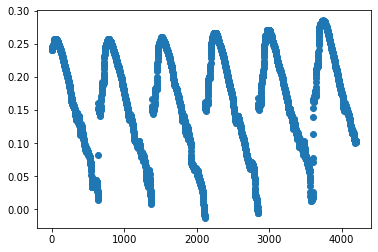

In [10]:
import matplotlib.pyplot as plt

time_period = 'minutes'

df_time = df_copy.groupby(time_period).mean().reset_index()

downsampled_df = df_time.tail(21000).reset_index()

downsampled_df = downsampled_df[['signal_in_h2_in_o2_sensor']]
downsampled_df



def moving_average(data, window=3):
    return data.rolling(window=window).mean()


downsampled_1_df = pd.DataFrame()


downsampled_1_df['smoothed_value'] = moving_average(downsampled_df['signal_in_h2_in_o2_sensor'], window=3)
downsampled_1_df = downsampled_1_df.dropna()




test_li = []

skip = 5

for i in range(0, len(downsampled_1_df['smoothed_value']), skip):
    x = downsampled_1_df['smoothed_value'].iloc[i]
    test_li.append(x)
    
    
plt.scatter(x =list(range(0,len(test_li),1)) , y=test_li)

test_li = pd.DataFrame(test_li) 


In [11]:
n = 0.8
n = int(n * len(test_li))

train, test = test_li.iloc[:n], test_li.iloc[n:]




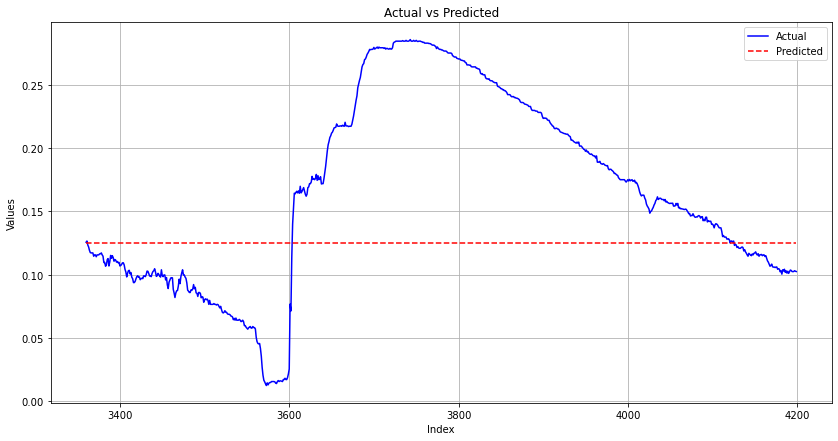

mean_absolute_error: 0.06954168536982362
Percentage RMSE: 51.62621804534832%


In [13]:
model = ExponentialSmoothing(train, trend=None, seasonal=None).fit()
y_es_pred = model.predict(start=test.index[0], end=test.index[-1])


y_pred_series = pd.Series(y_es_pred, index=test.index)


# Plotting
plt.figure(figsize=(14, 7))

plt.plot(test.index, test[0], label='Actual', color='blue')
plt.plot(test.index, y_pred_series, label='Predicted', color='red', linestyle='--')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


print(f'mean_absolute_error: {mean_absolute_error(test[0], y_pred_series )}')

rmse = np.sqrt(mean_squared_error( test[0], y_pred_series))
percentage_rmse = (rmse / test[0].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")

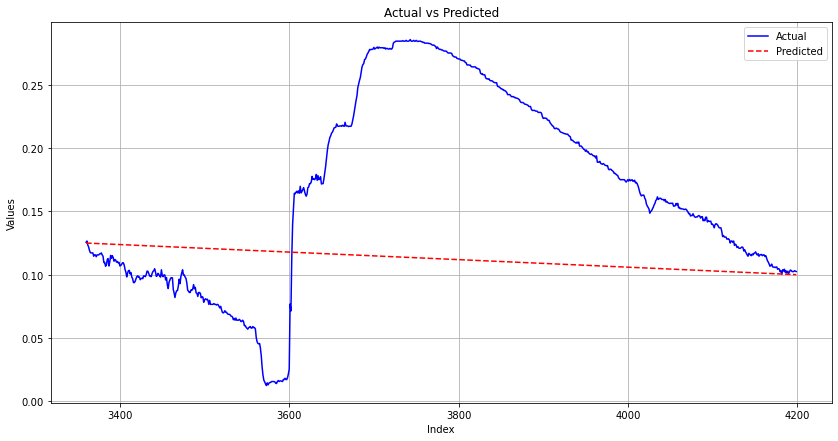

mean_absolute_error: 0.07753837833907155
Percentage RMSE: 56.68599400287917%


In [14]:
model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
y_es_pred = model.predict(start=test.index[0], end=test.index[-1])


y_pred_series = pd.Series(y_es_pred, index=test.index)


# Plotting
plt.figure(figsize=(14, 7))

plt.plot(test.index, test[0], label='Actual', color='blue')
plt.plot(test.index, y_pred_series, label='Predicted', color='red', linestyle='--')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

print(f'mean_absolute_error: {mean_absolute_error(test[0], y_pred_series )}')
rmse = np.sqrt(mean_squared_error( test[0], y_pred_series))
percentage_rmse = (rmse / test[0].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")

Optimization failed to converge. Check mle_retvals.


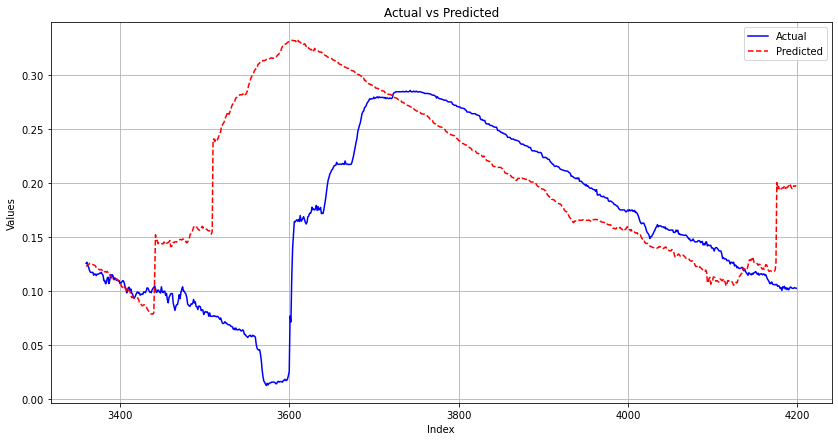

mean_absolute_error: 0.06069273896246256
Percentage RMSE: 58.68041960862445%


In [16]:



model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=1400).fit()
y_es_pred = model.predict(start=test.index[0], end=test.index[-1])


y_pred_series = pd.Series(y_es_pred, index=test.index)


# Plotting
plt.figure(figsize=(14, 7))

plt.plot(test.index, test[0], label='Actual', color='blue')
plt.plot(test.index, y_pred_series, label='Predicted', color='red', linestyle='--')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


print(f'mean_absolute_error: {mean_absolute_error(test[0], y_pred_series )}')

rmse = np.sqrt(mean_squared_error( test[0], y_pred_series))
percentage_rmse = (rmse / test[0].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")

Optimization failed to converge. Check mle_retvals.


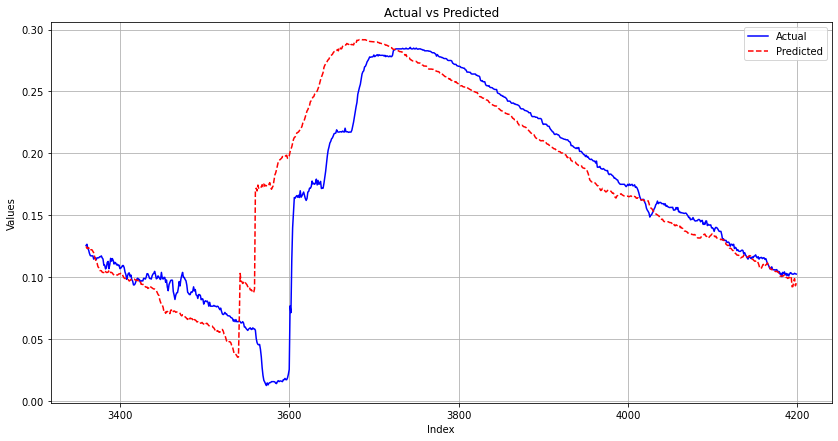

mean_absolute_error: 0.02473499344228604
Percentage RMSE: 26.435043161547057%


In [17]:

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=1450).fit()
y_es_pred = model.predict(start=test.index[0], end=test.index[-1])


y_pred_series = pd.Series(y_es_pred, index=test.index)


# Plotting
plt.figure(figsize=(14, 7))

plt.plot(test.index, test[0], label='Actual', color='blue')
plt.plot(test.index, y_pred_series, label='Predicted', color='red', linestyle='--')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


print(f'mean_absolute_error: {mean_absolute_error(test[0], y_pred_series )}')

rmse = np.sqrt(mean_squared_error( test[0], y_pred_series))
percentage_rmse = (rmse / test[0].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")


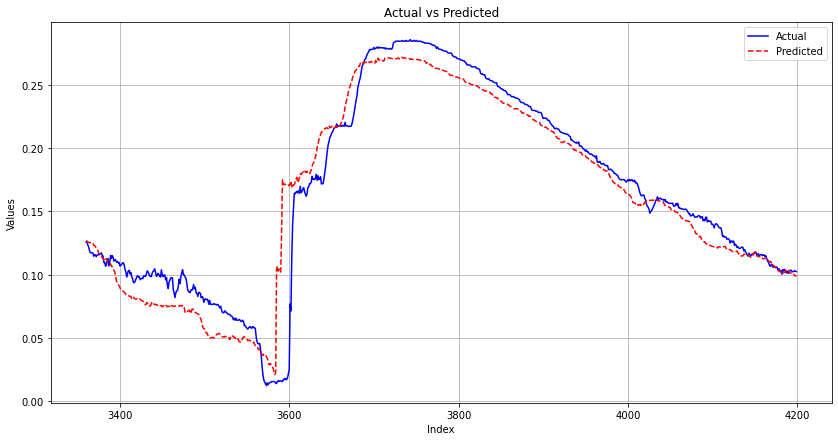

mean_absolute_error: 0.0139399057085823
Percentage RMSE: 13.919517137078124%


In [18]:

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=1475).fit()
y_es_pred = model.predict(start=test.index[0], end=test.index[-1])


y_pred_series = pd.Series(y_es_pred, index=test.index)


# Plotting
plt.figure(figsize=(14, 7))

plt.plot(test.index, test[0], label='Actual', color='blue')
plt.plot(test.index, y_pred_series, label='Predicted', color='red', linestyle='--')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


print(f'mean_absolute_error: {mean_absolute_error(test[0], y_pred_series )}')

rmse = np.sqrt(mean_squared_error( test[0], y_pred_series))
percentage_rmse = (rmse / test[0].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")

In [100]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import numpy as np

# Define your time series data
train_data = train+1e-6  # Ensure 'train' is a pandas Series or DataFrame column, times by 1e6 to ensure no negative values




# Define the objective function that Bayesian optimization will minimize
def objective(params):
    smoothing_level, smoothing_slope, smoothing_seasonal, damping_slope, seasonal_periods, seasonal = params
    
    try:
        model = ExponentialSmoothing(
            train_data,
            seasonal=seasonal,
            trend='add',
            seasonal_periods=int(seasonal_periods),
            damped_trend=True,
            initialization_method="estimated" 
        )
        
        fitted_model = model.fit(
            smoothing_level=smoothing_level,
            smoothing_slope=smoothing_slope,
            smoothing_seasonal=smoothing_seasonal,
            damping_slope=damping_slope
        )
        
        print("Current parameters:", params)
        
        # Check if fittedvalues is a DataFrame (multiple components)
        if isinstance(fitted_model.fittedvalues, pd.DataFrame):
            # Sum the components to get the total fitted values
            fitted_values = fitted_model.fittedvalues.sum(axis=1)
        else:
            # If it's already a Series, use it directly
            fitted_values = fitted_model.fittedvalues
        
        # Align indexes if necessary
        fitted_values = fitted_values.reset_index(drop=True)
        train_values = train_data.reset_index(drop=True)
        
        # Ensure both are pandas Series for subtraction
        if isinstance(fitted_values, pd.DataFrame):
            fitted_values = fitted_values.iloc[:, 0]
        if isinstance(train_values, pd.DataFrame):
            train_values = train_values.iloc[:, 0]
        
        residuals = fitted_values - train_values
    
        print("Residuals:", residuals)
        
        # Calculate RMSE
        mse = np.mean(residuals ** 2)  # Mean Squared Error
        rmse = np.sqrt(mse)  # Root Mean Squared Error
        print(rmse)
        
        percentage_rmse = (rmse / train_values.mean()) * 100
        print(f"Percentage RMSE: {percentage_rmse}%")

        return rmse
    except Exception as e:
        print("Error:", e)
        # Return a large number to indicate failure
        return float("inf")
    
    
    
# Define the search space for hyperparameters
search_space = [
    Real(0.1, 0.9, name='smoothing_level'),
    Real(0.01, 0.7, name='smoothing_slope'),
    Real(0.01, 0.3, name='smoothing_seasonal'),
    Real(0.8, 1.0, name='damping_slope'),
    Integer(1475, 1550, name='seasonal_periods'),  # Ensure this range fits your data
    Categorical(['add'], name='seasonal')
]

# Perform Bayesian optimization
result = gp_minimize(objective, search_space, n_calls=50, random_state=0)

# Print the best parameters and lowest RMSE
print(f"Best parameters: {result.x}")
print(f"Lowest RMSE: {result.fun}")


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.5742756945800148, 0.5925433665209021, 0.2588042291105995, 0.9694503477568251, 1522, 'add']
Residuals: 0      -0.000159
1       0.000204
2       0.000039
3      -0.000853
4       0.000481
          ...   
3355   -0.001235
3356   -0.000549
3357   -0.000301
3358    0.003353
3359   -0.002582
Length: 3360, dtype: float64
0.004835783715296659
Percentage RMSE: 2.991423187382638%
Current parameters: [0.3380276852355779, 0.049131954349035806, 0.08907032542823283, 0.89553302346427, 1536, 'add']
Residuals: 0      -0.000540
1       0.000606
2       0.000073
3      -0.000058
4       0.000478
          ...   
3355   -0.001770
3356   -0.000417
3357   -0.001049
3358    0.002005
3359   -0.001199
Length: 3360, dtype: float64
0.005252111244255428
Percentage RMSE: 3.2489640322581983%
Current parameters: [0.4142278368806639, 0.5868943468407907, 0.10784488652100784, 0.9296343744102394, 1503, 'add']
Residuals: 0      -0.000655
1       0.000531
2       0.000301
3      -0.000446
4      -

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
Optimization failed to converge. Check mle_retvals.


Current parameters: [0.9, 0.07947062325171465, 0.01, 0.8, 1550, 'add']
Residuals: 0      -0.000032
1       0.000716
2       0.000171
3      -0.000779
4       0.000374
          ...   
3355    0.000157
3356    0.000914
3357   -0.000437
3358    0.002420
3359   -0.002211
Length: 3360, dtype: float64
0.003771785935752633
Percentage RMSE: 2.3332325369233295%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.9, 0.33191806308885685, 0.01, 1.0, 1475, 'add']
Residuals: 0      -0.000075
1       0.000537
2      -0.000203
3      -0.000916
4       0.000749
          ...   
3355   -0.002196
3356   -0.000548
3357   -0.000239
3358    0.003416
3359   -0.002044
Length: 3360, dtype: float64
0.0041180900784485155
Percentage RMSE: 2.5474568081764493%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.7836086179926759, 0.10704001900767267, 0.01, 0.8, 1480, 'add']
Residuals: 0      -0.000160
1       0.000516
2       0.000096
3      -0.001050
4       0.000557
          ...   
3355    0.000582
3356    0.000916
3357    0.000030
3358    0.002434
3359   -0.002455
Length: 3360, dtype: float64
0.003917381876917574
Percentage RMSE: 2.423298408358377%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.8945532850603143, 0.2821229395903713, 0.28334583314668865, 0.8095094141515451, 1489, 'add']
Residuals: 0       0.000074
1       0.000193
2      -0.000271
3      -0.000451
4       0.000472
          ...   
3355   -0.002267
3356    0.000063
3357   -0.000661
3358    0.001792
3359   -0.004503
Length: 3360, dtype: float64
0.004316807451597676
Percentage RMSE: 2.6703836785188497%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.6808019480602091, 0.12080347535287632, 0.2624909365537947, 0.9136684899155515, 1503, 'add']
Residuals: 0      -0.000020
1       0.000677
2       0.000143
3      -0.000473
4      -0.000191
          ...   
3355   -0.001732
3356    0.000171
3357   -0.000363
3358    0.003518
3359   -0.001989
Length: 3360, dtype: float64
0.0043616839346500595
Percentage RMSE: 2.69814433943229%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.2781173445929874, 0.2775369445832697, 0.04556213682627387, 0.8797217626176215, 1487, 'add']
Residuals: 0      -0.000500
1       0.000388
2       0.000740
3      -0.000342
4       0.000542
          ...   
3355   -0.002998
3356   -0.002447
3357   -0.002860
3358    0.000367
3359   -0.001715
Length: 3360, dtype: float64
0.005376707768596175
Percentage RMSE: 3.326039632393332%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
Optimization failed to converge. Check mle_retvals.


Current parameters: [0.9, 0.01, 0.01, 0.9118125056149037, 1530, 'add']
Residuals: 0      -0.000100
1       0.001051
2       0.000374
3      -0.000305
4       0.000419
          ...   
3355   -0.000617
3356    0.000465
3357   -0.000057
3358    0.003177
3359   -0.001764
Length: 3360, dtype: float64
0.0038332597382226843
Percentage RMSE: 2.3712603249618627%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.5720260973696667, 0.38948383402674175, 0.06424775759138167, 0.8716554276758155, 1521, 'add']
Residuals: 0      -0.000593
1       0.001201
2      -0.000367
3      -0.000808
4      -0.000100
          ...   
3355   -0.001808
3356   -0.000316
3357   -0.000604
3358    0.003012
3359   -0.001792
Length: 3360, dtype: float64
0.004324742801407769
Percentage RMSE: 2.675292498023497%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.2130260907401882, 0.18134649118625248, 0.2869727192900657, 0.9784110729124663, 1540, 'add']
Residuals: 0      -0.000503
1       0.000321
2       0.000337
3      -0.000031
4       0.000711
          ...   
3355   -0.000780
3356   -0.000865
3357   -0.001094
3358    0.002637
3359   -0.001999
Length: 3360, dtype: float64
0.0068049647858229225
Percentage RMSE: 4.209561603270384%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.46675413384784814, 0.3120269125674274, 0.17543840127681817, 0.909660761148016, 1507, 'add']
Residuals: 0      -0.000324
1       0.000566
2       0.000029
3      -0.000485
4       0.000232
          ...   
3355   -0.000276
3356    0.001248
3357   -0.000316
3358    0.002965
3359   -0.001774
Length: 3360, dtype: float64
0.004816132097258436
Percentage RMSE: 2.97926666646894%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.519607258474048, 0.22753931487347212, 0.2064269475021907, 0.9953069603298613, 1508, 'add']
Residuals: 0      -0.000104
1       0.000570
2      -0.000022
3      -0.000855
4       0.000893
          ...   
3355   -0.000301
3356    0.000684
3357    0.001506
3358    0.004325
3359   -0.002295
Length: 3360, dtype: float64
0.004810354397955805
Percentage RMSE: 2.9756925728615387%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
Optimization failed to converge. Check mle_retvals.


Current parameters: [0.5198890297284992, 0.2336047310723227, 0.015953020353342822, 0.84500961118416, 1534, 'add']
Residuals: 0      -0.000216
1       0.000517
2       0.000119
3      -0.000649
4       0.000459
          ...   
3355   -0.001147
3356   -0.000195
3357   -0.000372
3358    0.002662
3359   -0.001260
Length: 3360, dtype: float64
0.004282741768165511
Percentage RMSE: 2.649310594751545%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.9, 0.01, 0.01, 0.8, 1475, 'add']
Residuals: 0      -0.000064
1       0.000556
2      -0.000016
3      -0.000834
4       0.000584
          ...   
3355   -0.001868
3356   -0.000902
3357   -0.000786
3358    0.002762
3359   -0.001701
Length: 3360, dtype: float64
0.003819148173397146
Percentage RMSE: 2.3625308894215933%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.3194517901923431, 0.27111808137844023, 0.19300062841749724, 0.9941733512219023, 1532, 'add']
Residuals: 0      -0.000595
1       0.000640
2       0.000443
3      -0.000148
4       0.000441
          ...   
3355   -0.002058
3356   -0.000387
3357   -0.001141
3358    0.002721
3359   -0.000716
Length: 3360, dtype: float64
0.0057416944229572555
Percentage RMSE: 3.551820933878601%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.6688973176579133, 0.17873696879029796, 0.12610156274959214, 0.9800777512642317, 1533, 'add']
Residuals: 0      -0.000206
1       0.000750
2       0.000114
3      -0.000886
4       0.000205
          ...   
3355   -0.001768
3356    0.000239
3357   -0.000460
3358    0.003839
3359   -0.002697
Length: 3360, dtype: float64
0.004345545106025796
Percentage RMSE: 2.6881608354118134%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
Optimization failed to converge. Check mle_retvals.


Current parameters: [0.9, 0.01, 0.01, 0.8, 1550, 'add']
Residuals: 0      -0.000102
1       0.000863
2       0.000334
3      -0.000618
4       0.000470
          ...   
3355    0.000153
3356    0.000934
3357   -0.000386
3358    0.002441
3359   -0.002069
Length: 3360, dtype: float64
0.0037751849021820756
Percentage RMSE: 2.3353351427445963%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.5574176367842657, 0.42902415987543974, 0.020508628319727627, 0.9301613739581445, 1492, 'add']
Residuals: 0      -0.000214
1       0.000498
2       0.000126
3      -0.000898
4       0.000333
          ...   
3355    0.000670
3356    0.002065
3357    0.002119
3358    0.003794
3359   -0.002773
Length: 3360, dtype: float64
0.0042901439954593406
Percentage RMSE: 2.6538896238539005%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.12533377507943053, 0.5672615301016873, 0.1958466828877363, 0.9899711508157749, 1521, 'add']
Residuals: 0      -0.000744
1       0.000994
2       0.000448
3       0.000069
4       0.000454
          ...   
3355   -0.003722
3356   -0.003712
3357   -0.004435
3358   -0.000666
3359   -0.003674
Length: 3360, dtype: float64
0.008775628659653157
Percentage RMSE: 5.428617283545244%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
Optimization failed to converge. Check mle_retvals.


Current parameters: [0.6944561351893161, 0.01, 0.01, 0.8, 1550, 'add']
Residuals: 0      -0.000268
1       0.000767
2       0.000522
3      -0.000489
4       0.000416
          ...   
3355    0.000345
3356    0.000919
3357   -0.000191
3358    0.002343
3359   -0.001645
Length: 3360, dtype: float64
0.003978608378692072
Percentage RMSE: 2.4611732158091733%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.10643465189535482, 0.4569909272295765, 0.035729950648129255, 0.8052136043773287, 1509, 'add']
Residuals: 0      -0.001014
1      -0.000121
2       0.000184
3       0.000425
4       0.000800
          ...   
3355    0.000683
3356    0.001554
3357    0.001642
3358    0.005264
3359    0.003109
Length: 3360, dtype: float64
0.006412411702358529
Percentage RMSE: 3.9667276666657774%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.810437498485176, 0.4698115362710223, 0.2769844226896428, 0.9993031748692764, 1529, 'add']
Residuals: 0       0.000088
1       0.000389
2      -0.000558
3      -0.000532
4       0.000375
          ...   
3355   -0.001069
3356    0.001218
3357   -0.000283
3358    0.004024
3359   -0.003994
Length: 3360, dtype: float64
0.004700707290225387
Percentage RMSE: 2.9078647046596022%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.41582329156475284, 0.03545557419718517, 0.29547527564179044, 0.8022807751856647, 1506, 'add']
Residuals: 0      -0.000247
1       0.000616
2       0.000477
3      -0.000128
4       0.000278
          ...   
3355    0.000279
3356    0.001225
3357    0.000036
3358    0.003969
3359   -0.000621
Length: 3360, dtype: float64
0.005229263657675841
Percentage RMSE: 3.2348304803266448%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.8999900522402435, 0.06895672997880224, 0.2926497366437015, 0.9887321065566306, 1484, 'add']
Residuals: 0       0.000155
1       0.000576
2       0.000062
3      -0.000519
4       0.000546
          ...   
3355   -0.001673
3356    0.001908
3357   -0.001328
3358    0.004406
3359   -0.002637
Length: 3360, dtype: float64
0.004377272329926055
Percentage RMSE: 2.707787344543373%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.5559370153579194, 0.6909887534917989, 0.11272806984259214, 0.8413544550811224, 1525, 'add']
Residuals: 0      -0.000200
1       0.000454
2      -0.000333
3      -0.000873
4       0.000285
          ...   
3355   -0.000906
3356    0.000713
3357    0.000214
3358    0.003578
3359   -0.002860
Length: 3360, dtype: float64
0.004370897590937734
Percentage RMSE: 2.7038439212751126%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.6853859119547346, 0.08629078437716997, 0.1578215237189064, 0.9760063138699497, 1519, 'add']
Residuals: 0      -0.000149
1       0.000728
2      -0.000074
3       0.000198
4       0.000294
          ...   
3355   -0.001339
3356   -0.000158
3357   -0.001053
3358    0.002976
3359   -0.003438
Length: 3360, dtype: float64
0.0043044674580614084
Percentage RMSE: 2.6627501396821613%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.45736717484101386, 0.6920091993687609, 0.18958116830728255, 0.8050501211688631, 1520, 'add']
Residuals: 0      -0.000426
1       0.000306
2       0.000318
3      -0.001234
4      -0.000380
          ...   
3355   -0.001567
3356   -0.000075
3357    0.000245
3358    0.003127
3359   -0.002190
Length: 3360, dtype: float64
0.0046780022108433295
Percentage RMSE: 2.8938193078979553%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.8512229890796918, 0.6835871072657094, 0.01, 0.8, 1550, 'add']
Residuals: 0      -0.000106
1       0.000223
2      -0.000315
3      -0.001075
4       0.000562
          ...   
3355   -0.000354
3356    0.000583
3357   -0.000855
3358    0.002365
3359   -0.003031
Length: 3360, dtype: float64
0.004034580358678093
Percentage RMSE: 2.495797568061376%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.6342452394725706, 0.564487684827043, 0.0806801015529842, 0.8854506236809727, 1530, 'add']
Residuals: 0      -0.000244
1       0.000498
2      -0.000143
3      -0.000871
4      -0.000036
          ...   
3355   -0.000407
3356    0.000797
3357    0.000230
3358    0.003553
3359   -0.002152
Length: 3360, dtype: float64
0.004320977210583923
Percentage RMSE: 2.6729630977922554%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
Optimization failed to converge. Check mle_retvals.


Current parameters: [0.7496789136086577, 0.01, 0.01, 0.8893947383648985, 1550, 'add']
Residuals: 0      -0.000165
1       0.000647
2       0.000431
3      -0.000463
4       0.000533
          ...   
3355    0.000272
3356    0.000918
3357   -0.000213
3358    0.002416
3359   -0.001811
Length: 3360, dtype: float64
0.0039052306064608433
Percentage RMSE: 2.415781613906747%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
Optimization failed to converge. Check mle_retvals.


Current parameters: [0.8628278022699121, 0.01, 0.01, 0.8, 1550, 'add']
Residuals: 0      -0.000044
1       0.000745
2       0.000329
3      -0.000659
4       0.000472
          ...   
3355    0.000231
3356    0.000906
3357   -0.000278
3358    0.002414
3359   -0.001970
Length: 3360, dtype: float64
0.00379837077745767
Percentage RMSE: 2.3496779605798475%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.7984727402369145, 0.41013340737444925, 0.04946578304888291, 0.9221699298348996, 1506, 'add']
Residuals: 0       0.000017
1       0.000291
2      -0.000232
3      -0.000766
4       0.000426
          ...   
3355   -0.000852
3356    0.000680
3357   -0.000645
3358    0.002979
3359   -0.002644
Length: 3360, dtype: float64
0.004223894280397257
Percentage RMSE: 2.6129074489962205%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.1470813497411701, 0.6081808450563633, 0.10760280963602672, 0.9684111385994403, 1526, 'add']
Residuals: 0      -0.001290
1       0.000368
2       0.000414
3       0.000145
4       0.000859
          ...   
3355   -0.002018
3356   -0.001510
3357   -0.001382
3358    0.002453
3359   -0.000341
Length: 3360, dtype: float64
0.0071517667186632465
Percentage RMSE: 4.424093808266657%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
Optimization failed to converge. Check mle_retvals.


Current parameters: [0.7485917826422641, 0.01, 0.1555894787649674, 0.8, 1550, 'add']
Residuals: 0      -0.000052
1       0.000758
2       0.000394
3      -0.000566
4       0.000264
          ...   
3355    0.000212
3356    0.001011
3357   -0.000411
3358    0.002770
3359   -0.002074
Length: 3360, dtype: float64
0.004123926955667839
Percentage RMSE: 2.551067509333442%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
Optimization failed to converge. Check mle_retvals.


Current parameters: [0.9, 0.01, 0.01, 0.8342634595444997, 1550, 'add']
Residuals: 0      -0.000117
1       0.000837
2       0.000347
3      -0.000575
4       0.000533
          ...   
3355    0.000157
3356    0.000937
3357   -0.000384
3358    0.002443
3359   -0.002068
Length: 3360, dtype: float64
0.0037753758937147264
Percentage RMSE: 2.335453290398214%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.3891021894639126, 0.20051967994483427, 0.01721016516679036, 0.9877316325561902, 1520, 'add']
Residuals: 0      -0.000708
1       0.000470
2       0.000981
3      -0.000378
4       0.000297
          ...   
3355   -0.002014
3356   -0.001190
3357   -0.000946
3358    0.001610
3359   -0.001784
Length: 3360, dtype: float64
0.005118083379312828
Percentage RMSE: 3.1660541904312294%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.22317050842150724, 0.1655723782444418, 0.12739007788764756, 0.8636989522989917, 1531, 'add']
Residuals: 0      -0.001093
1       0.000476
2       0.000611
3       0.000232
4       0.000751
          ...   
3355   -0.002071
3356   -0.001038
3357   -0.000955
3358    0.002740
3359   -0.000309
Length: 3360, dtype: float64
0.005980646462034177
Percentage RMSE: 3.6996370299761114%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.3621464923287664, 0.575546878526584, 0.26660598201899954, 0.8881482196722231, 1506, 'add']
Residuals: 0      -0.000339
1       0.000292
2       0.000096
3      -0.000514
4       0.000075
          ...   
3355   -0.001052
3356    0.000066
3357   -0.000895
3358    0.003221
3359   -0.001502
Length: 3360, dtype: float64
0.005343878830537173
Percentage RMSE: 3.3057316012015727%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.38158427286202845, 0.569212471485721, 0.01942658243689431, 0.868641789548888, 1525, 'add']
Residuals: 0      -0.000589
1       0.000503
2       0.000081
3      -0.000653
4       0.000212
          ...   
3355   -0.000872
3356    0.000401
3357    0.000341
3358    0.003412
3359   -0.001284
Length: 3360, dtype: float64
0.004598625336008457
Percentage RMSE: 2.844716651968183%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.5716875826027398, 0.49148295978416146, 0.05555919407123678, 0.932854666929634, 1479, 'add']
Residuals: 0      -0.000283
1       0.000494
2       0.000054
3      -0.000556
4       0.000008
          ...   
3355   -0.000626
3356    0.000177
3357   -0.001090
3358    0.002889
3359   -0.003080
Length: 3360, dtype: float64
0.004430466672017805
Percentage RMSE: 2.7406934457545318%


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


Current parameters: [0.3275440314631858, 0.5805927795708541, 0.2676726454390965, 0.8895172786364343, 1524, 'add']
Residuals: 0      -0.000270
1       0.000195
2       0.000017
3      -0.000190
4      -0.000055
          ...   
3355   -0.001088
3356    0.000400
3357    0.000458
3358    0.002934
3359   -0.001561
Length: 3360, dtype: float64
0.005296408037875738
Percentage RMSE: 3.2763660964041486%
Best parameters: [0.9, 0.07947062325171465, 0.01, 0.8, 1550, 'add']
Lowest RMSE: 0.003771785935752633


the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


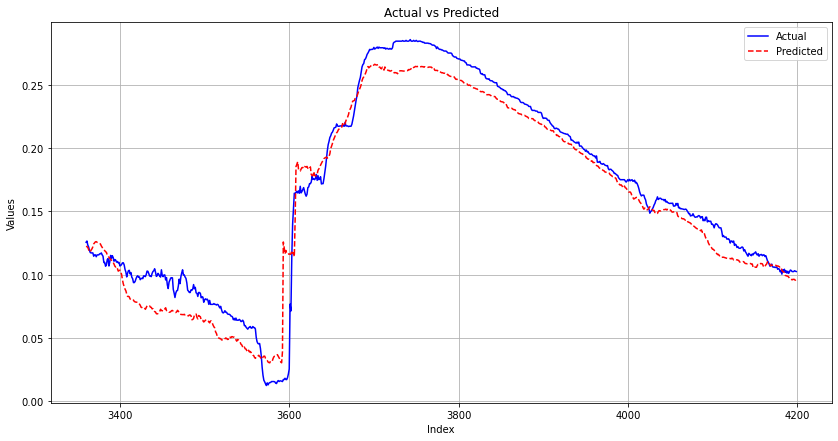

mean_absolute_error: 0.013635959684125653
Percentage RMSE: 10.66773508465824%


In [71]:

smoothing_level = 0.6765061237807335 
smoothing_slope = 0.41159365653182395
smoothing_seasonal = 0.16583823654021312
damping_slope = 0.9517231248644715
seasonal_periods = 1483
seasonal = 'add'

model = ExponentialSmoothing(
    train_data,
    seasonal=seasonal,
    trend='add',
    seasonal_periods=int(seasonal_periods),
    damped_trend=True,
    initialization_method="estimated" 
)

fitted_model = model.fit(
    smoothing_level=smoothing_level,
    smoothing_slope=smoothing_slope,
    smoothing_seasonal=smoothing_seasonal,
    damping_slope=damping_slope
)


y_es_pred = fitted_model.predict(start=test.index[0], end=test.index[-1])


y_pred_series = pd.Series(y_es_pred, index=test.index)


# Plotting
plt.figure(figsize=(14, 7))

plt.plot(test.index, test[0], label='Actual', color='blue')
plt.plot(test.index, y_pred_series, label='Predicted', color='red', linestyle='--')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


print(f'mean_absolute_error: {mean_absolute_error(test[0], y_pred_series )}')

rmse = np.sqrt(mean_squared_error( test[0], y_pred_series))
percentage_rmse = (rmse / test[0].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")



the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead


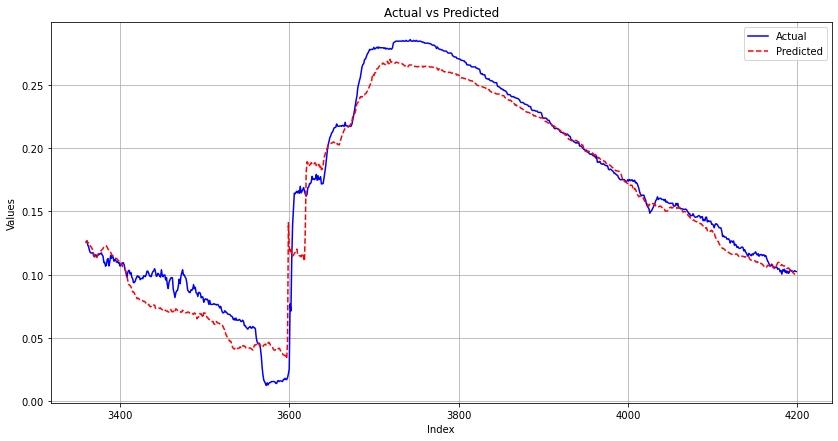

mean_absolute_error: 0.011318171193659219
Percentage RMSE: 9.425383835884817%


In [102]:
# Best parameters: [0.9, 0.07947062325171465, 0.01, 0.8, 1550, 'add']
# Lowest RMSE: 0.003771785935752633

# [0.8945532850603143, 0.2821229395903713, 0.28334583314668865, 0.8095094141515451, 1489, 'add']



smoothing_level = 0.8945532850603143 
smoothing_slope =  0.2821229395903713
smoothing_seasonal =  0.28334583314668865
damping_slope = 0.8095094141515451
seasonal_periods = 1489
seasonal = 'add'

model = ExponentialSmoothing(
    train_data,
    seasonal=seasonal,
    trend='add',
    seasonal_periods=int(seasonal_periods),
    damped_trend=True,
    initialization_method="estimated" 
)

fitted_model = model.fit(
    smoothing_level=smoothing_level,
    smoothing_slope=smoothing_slope,
    smoothing_seasonal=smoothing_seasonal,
    damping_slope=damping_slope
)


y_es_pred = fitted_model.predict(start=test.index[0], end=test.index[-1])


y_pred_series = pd.Series(y_es_pred, index=test.index)


# Plotting
plt.figure(figsize=(14, 7))

plt.plot(test.index, test[0], label='Actual', color='blue')
plt.plot(test.index, y_pred_series, label='Predicted', color='red', linestyle='--')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


print(f'mean_absolute_error: {mean_absolute_error(test[0], y_pred_series )}')

rmse = np.sqrt(mean_squared_error( test[0], y_pred_series))
percentage_rmse = (rmse / test[0].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")
